In [285]:
%%capture
!pip install fastparquet
!pip install pandarallel


In [ ]:
import stan
import numpy as np
import pandas as pd
import pickle
from src.utils import create_output_directories
import seaborn as sns
#Set up parallel processing
from pandarallel import pandarallel
from tqdm.notebook import trange, tqdm
from src.tables import get_table
import os
import pickle
os.environ["TMPDIR"] = "/home/joebak/tmp"
import nest_asyncio
import time
import string
nest_asyncio.apply()
pandarallel.initialize(nb_workers=8,verbose=True,progress_bar=True)
tqdm.pandas()
import arviz as az

#Make sure things reload
%load_ext autoreload
%autoreload 2

root = '.'
pal = sns.color_palette("Set2",n_colors=8)

create_output_directories()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<h1>Overview</h1>

Below is the code necessary to recreate the analysis from "Combining interventions to reduce the spread of viral misinformation." This notebook assumes that there is a folder located in "root" (default '.') called "data" containing:
<ol>
<li>Directory: Timeseries with subdirectories:</li>
    <ul>
    <li>aggressive</li>
    <li>modest</li>
    <li>currently</li>
    <li>Verified</li>
    <li>500k, 100k, 50k, 10k</li>
    <li>aggregated</li>
    <li>raw</li>
     </ul>
<li>ban_df_counts.parquet</li>
<li>events.parquet</li>
<li>incidents.parquet</li>
</ol>

Each of the subdirectories should contain aggregated time-series data, downloaded from LINK for each of the unfiltered events. This data were generated from our raw data which is not shared for privacy concerns. However, we include the code used to generate the aggregated time-series for application to novel datasets.


<h1>Segmentation and model fit</h1>

<h2>Segmentation</h2>

We begin by segmenting the time series of incidents into distinct events. Here, we define events as periods of heightened activity. Boundaries between events occur when the volume of tweets follows below 5% of the maximum 5-minute post volume for that event  (paramters before_min, after_min in srcseg.get_peaks). Events within an incident are included if their peak height is at least 30% of the maximum peak height across the entire incident (parameter pmin for srseg.get_peaks). 

In [ ]:
incidents = pd.read_csv('./data/incidents.csv')

In [ ]:
import src.segmentation as srcseg

def event_df(row):
    peaks = srcseg.get_peaks(row,root='.',start=0, freq=5,pmin=.3,
                      after_min=.05, before_min=.05)
    event_dictionaries = []
    for idx, peak in enumerate(peaks):
        one_event = {'incident_name':row['incident_name'],
                     'start':peak[0],
                     'end':peak[1],
                     'event_name':row['incident_name']+'_event_'+str(idx)}
        event_dictionaries.append(one_event)
    return pd.DataFrame(event_dictionaries)


events = pd.concat([pd.DataFrame(item) for item in incidents.T.parallel_apply(event_df,
                                                                     result_type='reduce')])
events = pd.merge(events, incidents, left_on='incident_name', right_on='incident_name')
events = events[(events['end'] - events['start']) >=12]
events.to_csv(root + '/data/events.csv',compression=None)
print('Found %s events' % str(events.shape[0]))
_ = events.T.parallel_apply(srcseg.plot_event)

Found 544 events


<h2> Fit model to all events </h2>

With events segmented, we turn to evaluating our model fit with regards to each event. Our model, in its simplest form  can be described as: 

\begin{equation}
\label{eq1}
\begin{aligned}
    y_{t} &=  \exp(\alpha + \beta v_{t-1})\\
    v_{t} &= v_{t-1} \delta e^{-\lambda t} + x[t] \\
    x_{t} &= \log(\sum_{j=1}^{y_t} F_{j})
\end{aligned}
\end{equation}

Where $y_t$ are the tweets at time $t$, $\alpha$ is the baseline rate of discussion, and $\beta$ is the effect of virality, $v$. Virality decays exponentially as a function of $\delta$ and $\lambda$. Here, $\delta$ captures the baseline rate of decay per time step, and $\lambda$ controls the way in which that decay changes over the lifetime of an event. This could either be due to algorithmic processes favoring new content or, for very large events, user saturation. Every time step, for each of $y_t$ accounts, the log sum ($x_t$) of their followers, $F_j$ is added to virality for the subsequent time step. We translate this into a bayesian statistical model such that: 

\begin{align*}
y_{t} &\sim \text{NegativeBinomial2}(\mu_{t}, \phi) \text{ for }t=2...T \\ 
\mu_{i} &= \exp(\alpha + \beta v_{t-1})\text{ for  }t=2...T \\ 
v_{t} &= v_{t-1}\delta e^{-\lambda t} + x_{t} \\
\alpha &\sim \text{Normal}(-3,3) \\
\beta &\sim \text{Normal}(0,3) \\
\delta &\sim \text{Beta}(2,2) \\
\lambda &\sim \text{HalfExponential}(1) \\
\phi &\sim \text{HalfExponential}(1) \\ 
v_{1} &= x_{1}\\
x_{t} &= \log(\sum_{j=1}^{y_t} F_{j}+1)
\end{align*}

This model can be found in /src/timeseries.stan. Because our model makes assumptions about how misinformation cascades spread, it is unlikely to fit everything that is considered an event. Ways in which we can identify a failed fit include parameters not converging, divergent transitions, or the posterior predictive distribution of cascade sizes not containing observed value. Here, we load the model and apply it to each segmented event. We then evaluate inclusion criteria and plot all successfully fitted events for visual inspection. Note that Stan will (and should) yell at us when events fail to fit. This is expected at this stage. 


In [ ]:
events = pd.read_csv(root + '/data/events.csv')

In [ ]:
events['duration'] = events['end'] - events['start']
events.sort_values('duration',inplace=True)#,ascending=False)
#open model code

    

In [ ]:
#Fit model to all events, save them. 
#This will take a while
#We will get some divergent transitions,warnings
#But we're not expecting our model to fit every time series
import src.model_fit as srcmf
diagnostics = []
for idx in tqdm(range(events.shape[0])):
    diagnostics.append(srcmf.fit_model(events.iloc[idx],keep=True))

  0%|          | 0/544 [00:00<?, ?it/s]

In [ ]:
import src.model_fit as srcmf

out= events.T.apply(srcmf.check_fit)
events = pd.DataFrame.from_records(out)

./output/posteriors/riot:_crimethinc_event_3_raw.p
--------
riot:_crimethinc_event_3
./output/posteriors/Prominent_Person:_Marjorie_Green_STS_event_1_raw.p
--------
Prominent_Person:_Marjorie_Green_STS_event_1
./output/posteriors/voting_info:_ads_say_vote_not_counted_event_0_raw.p
--------
voting_info:_ads_say_vote_not_counted_event_0
./output/posteriors/voting_info:_12th_Amendment_event_2_raw.p
--------
voting_info:_12th_Amendment_event_2
./output/posteriors/voting_info:_12th_Amendment_event_1_raw.p
--------
voting_info:_12th_Amendment_event_1
./output/posteriors/Digital_dumps:_AARP_Aggregate_event_0_raw.p
--------
Digital_dumps:_AARP_Aggregate_event_0
./output/posteriors/False_Victory:_Eric_Trump_Calls_PA_event_0_raw.p
--------
False_Victory:_Eric_Trump_Calls_PA_event_0
./output/posteriors/voting_info:_12th_Amendment_event_0_raw.p
--------
voting_info:_12th_Amendment_event_0
./output/posteriors/Prominent_Person:_Cuddy_Camaro_event_0_raw.p
--------
Prominent_Person:_Cuddy_Camaro_event

KeyboardInterrupt: 

<h3>Evaluate Inclusion</h3>

In [ ]:
events['included'] = (events['rhat'] & events['final_predicted'] \
                      &(events['end']-events['start'] >= 12))
print('Included %s events, %s percent of total' % (str(events['included'].sum()), 
                                           str(100*np.mean(events['included']))))
print('Total included tweets: %s' % str(np.sum(events[events['included']]['observed_engagement'])))
print('Total tweets: %s' % str(np.sum(events['observed_engagement'])))
events.to_csv('./data/events_fitted.csv',compression=None)

Included 485 events, 89.15441176470588 percent of total
Total included tweets: 12934852.0
Total tweets: 14263553.0


In [ ]:
np.mean(events['final_predicted'])

0.9944852941176471

In [ ]:
np.mean(events['rhat'])
events['observed_engagement'].sum()

14263553.0

In [ ]:
events.shape

(544, 20)

In [ ]:
events[events['included']]['observed_engagement'].sum()/events['observed_engagement'].sum()

0.9068464217856519

In [ ]:
events['included'].sum()

485

In [ ]:
events['included'].mean()

0.8915441176470589

<h3>Plot figures for review and SI</h3>

In [ ]:
events = pd.read_csv('./data/events_fitted.csv')

In [ ]:
from src.figures import plot_posterior_and_save
_ =events.T.parallel_apply(plot_posterior_and_save,keep=True)

In [ ]:
from src.figures import SI_Posterior
import seaborn as sns
# gridspec inside gridspec
sns.set_style('white')
included = events[events['included']]
SI_Posterior(included)


<h1>Simulations and output</h1>

Now that we have parameter estimates for all included events, we can use these parameters to simulate engagement while varying parameters. Our simulations (code in src.simulation.py) seed the first time-step with actual data. Beginning on the second time step, we estimate the number of new users that will share the content. We then draw follower counts from the observed follower counts at that time step in the data. The log of the sum of follower counts is added to the virality which is used in the subsequent time step to predict posts. This processes is repeated for the length of the observed event. We repeat this for all events, normalizing time on a 0-1 scale and summing the posteriori distributions to evaluate engagement. 

There's a wall of code ahead, but most of it is specifying the parameters for the simuations. This is accomplished with two dataframes. *included* specifies parmaters related a given event, and *sim_df* specifies the paramters for a given simulation of all events. We start by definining a baseline condition where no parameters of the model are altered and the aggregated data used includes all follower (i.e. from /data/timeseries/aggregated). We then modify this entry for various conditions either pointing the simulation to a different set of aggregated data with removed users, altering nudges, or implementing various removal and virality circuit breakers. This code should be expected to take a couple of hours with 8 cores and 500 simulations per event per condition (110000 total). 

The nice thing about this approach is that we can just send the rows we care about to the plotting function and get out the plots we want. Be careful when specifying which rows to be sure you're getting the right one. The nice thing is that by color coding conditions in the dataframe, it's pretty easy to see when you've snagged a wrong one. When in doubt, check *sim_df.iloc[[list_of_rows]]*. As we lack our color check when making tables, we're going to generate them along with figures just for a little safety. 


<h2>Define and run simulations</h2>

In [ ]:
events = pd.read_csv('./data/events_fitted.csv')
included = events[events['included']]
#This gets rid of an obnoxious warning
pd.options.mode.chained_assignment = None  # default='warn'

included['start'] = included['start'].astype('int')
included['end'] = included['end'].astype('int')

In [ ]:
#We need to add new columns so we can tell the simulation where to find
#aggregated files with certain thresholds of 3-strikes repeat offenders
#removed. 

#This gets rid of an obnoxious warning
pd.options.mode.chained_assignment = None  # default='warn'

included['data_loc']
base_loc = root + '/data/timeseries'

included.head()


,Unnamed: 0.2,Unnamed: 0.1,incident_name,start,end,event_name,Unnamed: 0,incident,count,duration,BFMI,rhat,observed_engagement,y_0,final_predicted,sample_loc,data_loc,lower_predicted,upper_predicted,included
0,0,374,riot:_crimethinc,34754,34766,riot:_crimethinc_event_3,313,riot: crimethinc,9458,12,True,True,88.0,0.0,True,./output/posteriors/riot:_crimethinc_event_3_r...,./data/timeseries/aggregated/riot:_crimethinc_...,43.0,176.0,True
1,1,349,Prominent_Person:_Marjorie_Green_STS,387,399,Prominent_Person:_Marjorie_Green_STS_event_1,297,Prominent Person: Marjorie Green STS,1050,12,True,True,327.0,3.0,True,./output/posteriors/Prominent_Person:_Marjorie...,./data/timeseries/aggregated/Prominent_Person:...,204.0,545.0,True
2,2,505,voting_info:_ads_say_vote_not_counted,2980,2992,voting_info:_ads_say_vote_not_counted_event_0,386,voting info: ads say vote not counted,436,12,True,True,23.0,0.0,True,./output/posteriors/voting_info:_ads_say_vote_...,./data/timeseries/aggregated/voting_info:_ads_...,11.0,39.0,True
3,3,498,voting_info:_12th_Amendment,707,719,voting_info:_12th_Amendment_event_2,384,voting info: 12th Amendment,5253,12,True,True,182.0,0.0,True,./output/posteriors/voting_info:_12th_Amendmen...,./data/timeseries/aggregated/voting_info:_12th...,102.0,338.0,True
4,4,497,voting_info:_12th_Amendment,670,682,voting_info:_12th_Amendment_event_1,384,voting info: 12th Amendment,5253,12,True,True,269.0,2.0,True,./output/posteriors/voting_info:_12th_Amendmen...,./data/timeseries/aggregated/voting_info:_12th...,138.0,543.0,True


<h3>

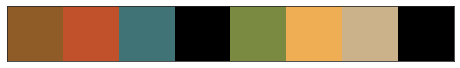

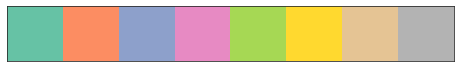

In [ ]:
pal_70s = [np.array([143,91,38])/255.0, 
           np.array([193,81,42])/255.0,
           np.array([64,115,117])/255.0,
           np.array([0,0,0])/255.0, 
           np.array([122,138,65])/255.0,
           np.array([239,174,84])/255.0,
           np.array([203,178,139])/255.0,
              np.array([0,0,0])/255.0]
sns.palplot(pal_70s)
pal = sns.color_palette("Set2",n_colors=8)
sns.palplot(pal)
pal = pal_70s

In [ ]:
largest_percentile = 1-.05


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [ ]:
import numpy as np
from tqdm.notebook import trange, tqdm
import pickle
import pandas as pd
import os
import json
from ast import literal_eval
   


             
baseline = dict(name='baseline',
                plot='All',
                num_sims=1,
                data_location = 'data_loc',
                color=np.array([38,38,38])/255.0,
                stop_at=np.inf, 
                nudge_value=.4,
                largest=True,
                nudge_start=0, 
                p_nudge=.1,
                freq=5)
ridx = 450
out_dicts = {}
row = included.iloc[ridx]
samples = pickle.load(open(row['sample_loc'],'rb'))
     
agg_df = pd.read_csv(row[baseline['data_location']])[row['start']:row['end']]
follower_distribution = [np.array(literal_eval(item)) for item in agg_df['follower_distribution'].values]
outs = []

for idx in range(baseline['num_sims']):
    out = simulate(samples,
            follower_distribution, 
            stop_at=baseline['stop_at'], nudge_value=baseline['nudge_value'], 
             nudge_start=baseline['nudge_start'],
            p_nudge=baseline['p_nudge'],
            chain=[np.random.choice(np.arange(samples.posterior['beta'].shape[0])), 
                   np.random.choice(np.arange(samples.posterior['beta'].shape[1]))],
            y=agg_df['total_tweets'].values)
    outs.append(out)
out_dicts[row['event_name']] = np.vstack(outs)
sim_row(baseline, included)



76066.0
82263.0
97772.0
48225.0
64930.0
68185.0
171777.0
351568.0
99769.0
96256.0
49584.0
79162.0
48293.0
52573.0
141728.0
84921.0
230805.0
68075.0
69501.0
95314.0
68658.0
88337.0
84723.0
158026.0
76881.0
112797.0
197088.0
129474.0
54305.0
59596.0
67693.0
53602.0
447503.0
167570.0
80984.0
116255.0
63786.0
52512.0
95301.0
260011.0
171048.0
149838.0
770319.0
1136546.0
242964.0
1524864.0
97690.0
720438.0
665099.0


In [ ]:
note_delays = pd.read_csv('./data/noteStatusHistory-00000.tsv',sep='\t')
note_data = pd.read_csv('./data/notes-00000.tsv',sep='\t')
merged = pd.merge(note_delays,note_data,on='noteId')


0.05017228609152095

In [328]:
#This is our baseline dictionary which we modify for various conditions. 
#Doing so ensures that we do not inadvertently set a parameter off baseline. 
baseline = dict(name='baseline',
                plot='All',
                num_sims=500,
                data_location = 'data_loc',
                color=np.array([38,38,38])/255.0,
                stop_at=np.inf, 
                nudge_value=1,
                nudge_start=0, 
                largest=False,
                p_nudge=0,
                alpha_mod = True,
                freq=5)
#Add removal at various delays
recs = [baseline]


helpful = note_delays[note_delays['currentStatus']=='CURRENTLY_RATED_HELPFUL']


#add time-lagged notes
#Add nudges


nudge_palette = np.array(sns.dark_palette(pal[0], reverse=True, n_colors=len(stops)+1))[1:]

nudges = [.66, .7, .75]
nudge_palette = sns.dark_palette(pal[2], reverse=False, n_colors=len(nudges)+1)[1:]
for idx in range(len(nudges)):
    add_row = baseline.copy()
    add_row['p_nudge'] = 1
    add_row['nudge_value'] = nudges[idx]
    add_row['color'] = nudge_palette[idx]
    add_row['alpha_mod'] = idx == 2
    add_row['name'] = 'nudge_' + str(nudges[idx])
    recs.append(add_row)
    
    
#calculate delays from note submission to deployment. 
time_to_deploy = (helpful['timestampMillisOfFirstNonNMRStatus'].astype('int')-helpful['createdAtMillis'].astype('int')) / 1000
np.min(time_to_deploy[time_to_deploy > 0])/60
np.min(time_to_deploy[time_to_deploy > 0])
stops = np.percentile(time_to_deploy[time_to_deploy > 0], [25, 50, 75])/60
stops = np.hstack([np.array(0), stops]).tolist()

delay_palette = np.array(sns.dark_palette(pal[1], reverse=True, n_colors=len(stops)+1))[1:]

for idx in range(len(stops)):
    add_row = baseline.copy()
    add_row['p_nudge'] = 1
    add_row['nudge_value'] = .7
    add_row['nudge_start'] = stops[idx]
    add_row['color'] = delay_palette[idx]
    add_row['alpha_mod'] = idx == 2
    add_row['name'] = 'nudgedelay_' + str(idx)
    recs.append(add_row)


#Add probababilistic nudging 
label_probs = [np.round(merged.groupby('tweetId').apply(lambda x: np.any(x['currentStatus']=='CURRENTLY_RATED_HELPFUL')).mean(),2), .25, .5, .75, 1]
missing_palettee = np.array(sns.dark_palette(pal[2], reverse=True, n_colors=len(label_probs)+1))[1:]

for idx in range(len(label_probs)):
    add_row = baseline.copy()
    add_row['p_nudge'] = label_probs[idx]
    add_row['nudge_value'] = .7
    add_row['color'] = missing_palettee[idx]
    add_row['alpha_mod'] = idx == 0
    add_row['name'] = 'probnudge_' + str(label_probs[idx])
    recs.append(add_row)

missing_palettee = np.array(sns.dark_palette(pal[5], reverse=True, n_colors=len(label_probs)+1))[1:]

for idx in range(len(label_probs)):
    add_row = baseline.copy()
    add_row['p_nudge'] = label_probs[idx]
    add_row['nudge_value'] = .7
    add_row['color'] = missing_palettee[idx]
    add_row['alpha_mod'] = idx == 0
    add_row['name'] = 'largest_' + str(label_probs[idx])
    add_row['largest']=True
    
    recs.append(add_row)
    
    
missing_palettee = np.array(sns.dark_palette(pal[4], reverse=True, n_colors=4))[1:]

add_row = baseline.copy()
add_row['p_nudge'] = label_probs[0]
add_row['nudge_value'] = .7
add_row['color'] = missing_palettee[0]
add_row['alpha_mod'] = True
add_row['nudge_start'] =  stops[2]
add_row['name'] = 'Summary_Plausible_' + str(label_probs[idx])
recs.append(add_row)

add_row = baseline.copy()
add_row['p_nudge'] = label_probs[0]
add_row['nudge_value'] = .7
add_row['color'] = missing_palettee[0]
add_row['alpha_mod'] = True
add_row['nudge_start'] =  stops[2]
add_row['largest']=True
add_row['name'] = 'Summary_PlausibleLargest_' + str(label_probs[idx])
recs.append(add_row)


add_row = baseline.copy()
add_row['p_nudge'] = label_probs[0]*2
add_row['nudge_value'] = .7
add_row['color'] = missing_palettee[1]
add_row['alpha_mod'] = False
add_row['nudge_start'] =  stops[2]/2
add_row['largest']=True
add_row['name'] = 'Summary_ImprovedLargest_' + str(label_probs[idx])
recs.append(add_row)


#


#['aggregated_loc','currently_loc','verified_loc']
sim_df = pd.DataFrame(recs)
sim_df.to_csv('./output/simulations/sim_df.csv')
sim_df


,name,plot,num_sims,data_location,color,stop_at,nudge_value,nudge_start,largest,p_nudge,alpha_mod,freq
0,baseline,All,500,data_loc,"[0.14901960784313725, 0.14901960784313725, 0.1...",inf,1.00,0.000000,False,0.00,True,5
1,nudge_0.66,All,500,data_loc,"(0.2801190201074747, 0.3076414712218474, 0.371...",inf,0.66,0.000000,False,1.00,False,5
2,nudge_0.7,All,500,data_loc,"(0.4165300982890315, 0.4675462258070021, 0.583...",inf,0.70,0.000000,False,1.00,False,5
3,nudge_0.75,All,500,data_loc,"(0.5529411764705883, 0.6274509803921569, 0.796...",inf,0.75,0.000000,False,1.00,True,5
4,nudgedelay_0,All,500,data_loc,"[0.7835133693360417, 0.44952708194361474, 0.32...",inf,0.70,0.000000,False,1.00,False,5
5,nudgedelay_1,All,500,data_loc,"[0.5787914445544361, 0.3461129874166412, 0.258...",inf,0.70,271.295883,False,1.00,False,5
6,nudgedelay_2,All,500,data_loc,"[0.37406951977283054, 0.24269889288966767, 0.1...",inf,0.70,571.609317,False,1.00,True,5
7,nudgedelay_3,All,500,data_loc,"[0.17254637506593765, 0.1409006435896781, 0.13...",inf,0.70,1176.881817,False,1.00,False,5
8,probnudge_0.05,All,500,data_loc,"[0.4710945295616542, 0.531508127641064, 0.6686...",inf,0.70,0.000000,False,0.05,True,5
9,probnudge_0.25,All,500,data_loc,"[0.38924788265272015, 0.4355652748899712, 0.54...",inf,0.70,0.000000,False,0.25,False,5


In [329]:
%load_ext autoreload
%autoreload 2
from src.simulation import *

#The keep parameter tells the simulations whether to re-run old simulations (False)
#or keep them. This is very useful if your notebook dies. Just set it to True
#and the simulations will pick up where they left off. 
sim_included = lambda row: sim_row(row, included,verbose=True,keep=True)
_ = sim_df.T.parallel_apply(sim_included)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [330]:
import matplotlib.pyplot as plt
import string
%matplotlib inline

In [331]:
sim_df = pd.read_csv('./output/simulations/sim_df.csv')


In [332]:
baseline = pickle.load(open('./output/simulations/baseline.p','rb'))

In [333]:
import matplotlib.pyplot as plt
%matplotlib inline

In [334]:
baseline['dead_voters:_general_ticket_event_3'].shape

(500, 1428)

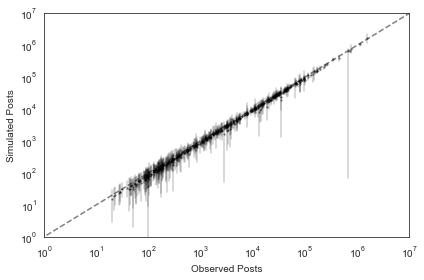

In [335]:
xs = np.zeros(included.shape[0])
ys = np.zeros(included.shape[0])
for idx in range(included.shape[0]):
    x=np.median(np.sum(baseline[included.iloc[idx]['event_name']],axis=1))
    ci=np.percentile(np.sum(baseline[included.iloc[idx]['event_name']],axis=1), 
                     q=[5.5,50, 94.5])
    y= ci[1]
    ci= [ci[0], ci[2]]

    x=included.iloc[idx]['observed_engagement']
    plt.scatter(x,y,color='k',alpha=.5,s=5,linewidth=0)
    plt.plot([x,x], [ci[0], ci[1]],alpha=.2, color='k')
    xs[idx] =x 
    ys[idx] = y
plt.plot([0, 1e7],[0, 1e7],ls='--',color='k',alpha=.5)

plt.xlabel('Observed Posts')
plt.ylabel('Simulated Posts')
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
plt.ylim(1,1e7)
plt.xlim(1,1e7)

plt.tight_layout()
plt.savefig('./output/figures/SI/SimulationValidation.png',dpi=400,transparent=False)
plt.savefig('./output/figures/SI/SimulationValidation.pdf')#,dpi=400,transparent=False)



<h2>Figures and Tables</h2>

<h3>Figure 1</h3>

In [336]:
        
def add_sim_line(sim_row,scale=1e6,root='.'):
    vals = pickle.load(open(root + '/output/simulations/' + sim_row['name'] +'.p', 'rb'))
    keys = [key for key in vals.keys()]
    one_output = vals[keys[0]]

    interp_size = 20
    one_output = vals[keys[0]]
    out = np.zeros((one_output.shape[0], interp_size))

    for key in keys:
        one_output = vals[key]
        cumulative_scaled = np.apply_along_axis(interp,arr=np.cumsum(one_output,axis=1),axis=1)
        out+= cumulative_scaled

    mu = np.median(out,axis=0)/scale
    ci = np.percentile(out,axis=0, q=[5.5,94.5])/scale
    xvals = np.linspace(0,1,interp_size)
   
 
    color = json.loads(sim_row['color'])
    plt.plot(xvals, mu,color=color)
    plt.fill_between(xvals, ci[0], ci[1],alpha=.4,facecolor=color, label=sim_row['name'])
    
    return out

def plot_sims(order, sim_df, legend_title, legend_column):
    for idx in order:
        _ = add_sim_line(sim_df.iloc[idx])

    labels = sim_df.iloc[order][legend_column].values.astype('str').tolist()
    labels[0] = 'Base.'
    legend = plt.legend(labels=labels,title=legend_title,loc=2,prop={'size': 8})
    legend.get_title().set_fontsize('10')
    plt.ylim(0,12)
    plt.xlim(0,1)
    plt.xlabel('Time (normalized)')
    plt.ylabel('Cumulative posts')

In [337]:
sim_df

,Unnamed: 0,name,plot,num_sims,data_location,color,stop_at,nudge_value,nudge_start,largest,p_nudge,alpha_mod,freq
0,0,baseline,All,500,data_loc,[0.14901961 0.14901961 0.14901961],inf,1.00,0.000000,False,0.00,True,5
1,1,nudge_0.66,All,500,data_loc,"(0.2801190201074747, 0.3076414712218474, 0.371...",inf,0.66,0.000000,False,1.00,False,5
2,2,nudge_0.7,All,500,data_loc,"(0.4165300982890315, 0.4675462258070021, 0.583...",inf,0.70,0.000000,False,1.00,False,5
3,3,nudge_0.75,All,500,data_loc,"(0.5529411764705883, 0.6274509803921569, 0.796...",inf,0.75,0.000000,False,1.00,True,5
4,4,nudgedelay_0,All,500,data_loc,[0.78351337 0.44952708 0.32135995],inf,0.70,0.000000,False,1.00,False,5
5,5,nudgedelay_1,All,500,data_loc,[0.57879144 0.34611299 0.25840618],inf,0.70,271.295883,False,1.00,False,5
6,6,nudgedelay_2,All,500,data_loc,[0.37406952 0.24269889 0.19545241],inf,0.70,571.609317,False,1.00,True,5
7,7,nudgedelay_3,All,500,data_loc,[0.17254638 0.14090064 0.13348229],inf,0.70,1176.881817,False,1.00,False,5
8,8,probnudge_0.05,All,500,data_loc,[0.47109453 0.53150813 0.66861044],inf,0.70,0.000000,False,0.05,True,5
9,9,probnudge_0.25,All,500,data_loc,[0.38924788 0.43556527 0.54114245],inf,0.70,0.000000,False,0.25,False,5


In [441]:
get_table(sim_df, order=np.arange(21))

,name,$\mu (\% change)$,5.5\%,94.5\%
0,baseline,12529470 (-0.0),11684659 (-0.0),13278291 (-0.0)
1,nudge_0.66,5780655 (-53.8),5614722 (-56.8),5932177 (-50.1)
2,nudge_0.7,6176342 (-50.7),5974884 (-53.8),6343845 (-46.7)
3,nudge_0.75,6729900 (-46.2),6509278 (-49.6),6953706 (-42.1)
4,nudgedelay_0,6161188 (-50.7),6010622 (-53.7),6340000 (-47.0)
5,nudgedelay_1,7831999 (-37.5),7612972 (-40.9),8072045 (-32.3)
6,nudgedelay_2,8564332 (-31.5),8315425 (-35.7),8843303 (-26.0)
7,nudgedelay_3,9519470 (-24.1),9230383 (-28.6),9805867 (-18.0)
8,probnudge_0.05,12318667 (-1.8),10976253 (-13.1),13140863 (8.1)
9,probnudge_0.25,11037889 (-12.1),9099434 (-26.8),12440266 (1.0)


In [369]:
from ast import literal_eval


[0.14901961, 0.14901961, 0.14901961]

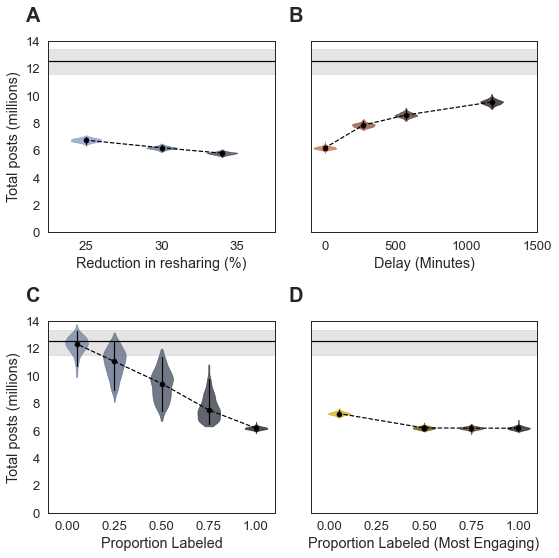

In [446]:
def plot_baseline(xmin,xmax, sim_df, ax,ymax=14):
    baseline = get_sim_cumulative(sim_df.iloc[0])/1000000
    baseline = baseline[:,-1]
    ax.plot([xmin, xmax], 
            [np.median(baseline),
            np.median(baseline)],
            c='k')
    percentile = np.percentile(baseline, 
                                    q=[3,97])
    plt.fill_between([xmin, xmax], 
                    [percentile[0], percentile[0]],
            [percentile[1], percentile[1]],
            color='grey',
            alpha=.2)
    plt.xlim(xmin,xmax)
    plt.ylim(0,ymax)
#plot_baseline(260, 14, sim_df, ax)
#Plot Nudges
def plot_nudges(sim_df,ax, nudges=[1,2,3],xmax=40,xmin=20,ymax=14,ymin=0,xtype='nudge_value',xlabel='Reduction in resharing (%)'):
    medians = []
    ptiles = []
    plt.sca(ax)
    for idx in range(len(nudges)):
            temp = get_sim_cumulative(sim_df.iloc[nudges[idx]])/1000000
            medians.append(np.median(temp[:,-1]))
            ptiles.append(np.percentile(temp[:,-1],q=[3,97]))
            try:
                c=literal_eval(sim_df.iloc[nudges[idx]]['color'])
            except:
                c=literal_eval(','.join(sim_df.iloc[nudges[idx]]['color'].split(' ')))
            
            if xtype=='nudge_value':
                xfunc = lambda x: 100 - (100*x)
            else:
                xfunc = lambda x: x
                
            parts = plt.violinplot(temp[:,-1],
                        positions=[xfunc(sim_df.iloc[nudges[idx]][xtype])],
                        widths=(xmax-xmin)/10,
                            showmedians=False,
                        showextrema=False)
            for pc in parts['bodies']:
                pc.set_facecolor(c)
                pc.set_edgecolor(c)
                pc.set_alpha(.8)

    plt.scatter(xfunc(sim_df.iloc[nudges][xtype]),medians,color='k',zorder=3)
    for idx in range(len(nudges)):
        x = xfunc(sim_df.iloc[nudges[idx]][xtype])
        plt.plot([x,x], ptiles[idx],color='k',zorder=3)

    plt.plot(xfunc(sim_df.iloc[nudges][xtype]),medians,color='k',ls='--',zorder=2)


    plt.xlabel(xlabel)
    plt.ylabel('Total posts (millions)')
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    
    
    
sns.set_style('white')
sns.set_context('paper', font_scale=1.5)  
#Plot Nudges
fig, axs = plt.subplots(2,2,figsize=(8,8),sharey=True)
axs = [axs[0][0], axs[0][1], axs[1][0], axs[1][1]]

plot_nudges(sim_df,axs[0],nudges=[1,2,3])
plot_baseline(22.5, 37.5,sim_df, axs[0])
axs[0].set_xticks([25,30,35])

plot_nudges(sim_df,axs[1],nudges=[7,6,5,4],xmin=-100,xmax=1500,xtype='nudge_start',xlabel='Delay (Minutes)')
plot_baseline(-100, 1500,sim_df, axs[1])
plt.ylabel('')

plot_nudges(sim_df,axs[2],nudges=[12,11,10,9,8],xmin=-.1,xmax=1.1,xtype='p_nudge',xlabel='Proportion Labeled')
plot_baseline(-.1, 1.1,sim_df, axs[2])

plot_nudges(sim_df,axs[3],nudges=[17,16,15,15,13],xmin=-.1,xmax=1.1,xtype='p_nudge',xlabel='Proportion Labeled (Most Engaging)')
plot_baseline(-.1, 1.1,sim_df, axs[3])
plt.ylabel('')

for n, ax in enumerate(axs):
    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=20, weight='bold')
    
    
plt.tight_layout()
plt.savefig('./output/figures/MS/Figure1.pdf')
plt.savefig('./output/figures/MS/Figure1.png', dpi=300)

<h2> Figure 2</h2>

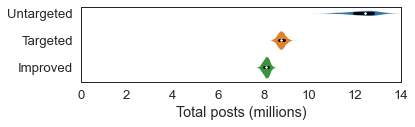

In [445]:
from matplotlib.collections import PolyCollection

def patch_violinplot():
    ax = plt.gca()
    for art in ax.get_children():
        if isinstance(art, PolyCollection):
            art.set_edgecolor((0.3, 0.3, 0.3))
                
import seaborn as sns
from src.figures import plot4c

plt.figure(figsize=(6,2))
axs = plt.gca()

plt.sca(axs)  
order = [18,19,20]


dfs = []
labels = ['Untargeted','Targeted', 'Improved' ] #Double check label ordering
medians = []
ptiles = []
for idx in range(len(order)):
    temp = get_sim_cumulative(sim_df.iloc[order[idx]])[:,-1]/1000000
    medians.append(np.median(temp))
    ptiles.append(np.percentile(temp, q=[25, 75]))
    dfs.append(pd.DataFrame({'condition': np.repeat(labels[idx], temp.shape), 
                   'posts':temp}))
sns.violinplot(x='posts', y='condition', alpha=.6,linewidth=0, data=pd.concat(dfs))#, palette=c)
plt.scatter(medians,np.arange(3),color='white',s=3,zorder=3)
for idx in range(len(ptiles)):
    plt.plot(ptiles[idx], [idx,idx],color='k',lw=3)
plt.xlabel('Total posts (millions)')
plt.xlim(0,14)

plt.ylabel('')


plt.tight_layout()
plt.savefig('./output/figures/MS/Figure2.png')
plt.savefig('./output/figures/MS/Figure2.pdf')